In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
import gc
import math
import random
import pickle
from collections import defaultdict
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split

DATA_DIR = 'open_track1'
CACHE_DIR = 'cache'
os.makedirs(CACHE_DIR, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Device: cuda


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import random
import pickle
import os

# 피처 차원 정의 (VIF 결과 반영)
N_SEQ_FEATURES = 22      # 시퀀스 피처
N_LP_FEATURES = 8        # 마지막 패스 물리적 정보 (sx, sy, prev_ex, prev_ey 등)
N_PLAYER_STATS = 5       # VIF 선별 선수 성향 (p_tend_dx, p_tend_dy 등)
N_TEAM_STATS = 4         # VIF 선별 팀 성향 (t_tend_dx 등)
N_STANDING_FEATURES = 3  # 순위, 포인트, 득실차
N_META_FEATURES = 4      # 라운드, 전후반, 홈여부 등

# 임베딩 차원
PLAYER_EMB_DIM = 32
TEAM_EMB_DIM = 16

In [15]:
# 데이터 로딩
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
match_info = pd.read_csv(f'{DATA_DIR}/match_info.csv')

game_round_map = match_info.set_index('game_id')['game_day'].to_dict()

print(f"Train 이벤트 개수: {len(train_df)}개")
print(f"선수: {train_df['player_id'].nunique()}명")
print(f"팀: {train_df['team_id'].nunique()}개")

Train 이벤트 개수: 356721개
선수: 446명
팀: 12개


In [18]:
def compute_pass_features(passes_df):
    """패스 파생 피처 계산"""
    df = passes_df.copy()
    df['pass_dist'] = np.sqrt((df['end_x'] - df['start_x'])**2 + (df['end_y'] - df['start_y'])**2)
    df['pass_dx'] = df['end_x'] - df['start_x']
    df['pass_dy'] = df['end_y'] - df['start_y']
    df['pass_angle'] = np.arctan2(df['pass_dy'], df['pass_dx'])
    df['is_forward'] = (df['pass_dx'] > 0).astype(int)
    df['is_backward'] = (df['pass_dx'] < -5).astype(int)
    df['is_successful'] = (df['result_name'] == 'Successful').astype(int)
    df['is_short'] = (df['pass_dist'] < 10).astype(int)
    df['zone_def'] = (df['start_x'] < 35).astype(int)
    df['zone_mid'] = ((df['start_x'] >= 35) & (df['start_x'] < 70)).astype(int)
    df['zone_att'] = (df['start_x'] >= 70).astype(int)
    df['is_left'] = (df['start_y'] < 22.67).astype(int)
    df['is_center'] = ((df['start_y'] >= 22.67) & (df['start_y'] <= 45.33)).astype(int)
    df['is_right'] = (df['start_y'] > 45.33).astype(int)
    return df

passes = train_df[train_df['type_name'] == 'Pass'].copy()
passes['round'] = passes['game_id'].map(game_round_map)
passes = compute_pass_features(passes)
print('=== 패스 특성 계산 ===')
print(f"총 패스 수: {len(passes)}")
print(passes.head())

=== 패스 특성 계산 ===
총 패스 수: 178582
   game_id  period_id  episode_id  time_seconds  team_id  player_id  \
0   126283          1           1         0.667     2354     344559   
1   126283          1           1         3.667     2354     250036   
3   126283          1           1         8.200     2354     500145   
4   126283          1           1        11.633     2354     142106   
6   126283          1           1        18.900     2354     500147   

   action_id type_name result_name    start_x  ...  is_forward  is_backward  \
0          0      Pass  Successful  52.418205  ...           0            1   
1          2      Pass  Successful  32.013240  ...           1            0   
3          5      Pass  Successful  38.391570  ...           0            0   
4          7      Pass  Successful  34.578705  ...           0            1   
6         10      Pass  Successful  28.862295  ...           0            0   

   is_successful  is_short zone_def  zone_mid  zone_att  is_left  

In [ ]:
def compute_cumulative_stats(passes, group_col, game_round_map):
    """그룹별 누적 통계 (경기 전까지의 데이터만 사용)"""
    game_stats = passes.groupby([group_col, 'game_id']).agg({
        'pass_dist': 'mean', 'pass_dy': 'mean', 'pass_angle': 'mean',
        'is_forward': 'mean', 'is_backward': 'mean', 'is_successful': 'mean',
        'is_short': 'mean', 'zone_def': 'mean', 'zone_mid': 'mean', 'zone_att': 'mean', 
        'is_left': 'mean', 'is_center': 'mean', 'is_right': 'mean',
        'start_x': 'mean', 'start_y': 'mean',
    }).reset_index()
    
    game_stats.columns = [group_col, 'game_id', 'pass_dist_mean', 'pass_dy_mean', 'pass_angle_mean',
                          'forward_rate', 'backward_rate', 'success_rate', 'short_rate',
                          'zone_def_rate', 'zone_mid_rate', 'zone_att_rate', 'left_rate', 'center_rate', 'right_rate',
                          'avg_start_x', 'avg_start_y']
    
    pass_counts = passes.groupby([group_col, 'game_id']).size().reset_index(name='pass_count')
    game_stats = game_stats.merge(pass_counts, on=[group_col, 'game_id'])
    game_stats['round'] = game_stats['game_id'].map(game_round_map)
    game_stats = game_stats.sort_values([group_col, 'round'])
    
    cumulative = []
    for gid in tqdm(game_stats[group_col].unique(), desc=f'{group_col} cumulative'):
        group_data = game_stats[game_stats[group_col] == gid].copy()
        for idx, row in group_data.iterrows():
            current_round = row['round']
            prev_data = group_data[group_data['round'] < current_round]
            
            if len(prev_data) == 0:
                cum = {f'cum_{col}': np.nan for col in ['pass_dist_mean', 'pass_dy_mean', 'pass_angle_mean',
                       'forward_rate', 'backward_rate', 'success_rate', 'short_rate',
                       'zone_def_rate', 'zone_mid_rate', 'zone_att_rate', 'left_rate', 'center_rate', 'right_rate',
                       'avg_start_x', 'avg_start_y', 'total_passes', 'games_played']}
            else:
                cum = {f'cum_{col}': prev_data[col].mean() for col in 
                       ['pass_dist_mean', 'pass_dy_mean', 'pass_angle_mean', 'forward_rate', 'backward_rate',
                        'success_rate', 'short_rate', 'zone_def_rate', 'zone_mid_rate', 'zone_att_rate',
                        'left_rate', 'center_rate', 'right_rate', 'avg_start_x', 'avg_start_y']}
                cum['cum_total_passes'] = prev_data['pass_count'].sum()
                cum['cum_games_played'] = len(prev_data)
            
            cum[group_col] = gid
            cum['game_id'] = row['game_id']
            cum['round'] = current_round
            cumulative.append(cum)
    return pd.DataFrame(cumulative)

print("선수별 누적 통계 계산...")
player_cumulative = compute_cumulative_stats(passes, 'player_id', game_round_map)
print(f"선수 누적: {player_cumulative.shape}")

print("팀별 누적 통계 계산...")
team_cumulative = compute_cumulative_stats(passes, 'team_id', game_round_map)
print(f"팀 누적: {team_cumulative.shape}")

선수별 누적 통계 계산...


player_id cumulative: 100%|██████████| 446/446 [00:14<00:00, 31.50it/s]


선수 누적: (6134, 20)
팀별 누적 통계 계산...


team_id cumulative: 100%|██████████| 12/12 [00:00<00:00, 12.56it/s]

팀 누적: (396, 20)


In [34]:
print(player_cumulative.head())

          cum_pass_dist_mean           cum_pass_dy_mean  \
0  <built-in function zeros>  <built-in function zeros>   
1                  18.592347                   7.000594   
2                   17.94457                   4.623241   
3                  17.076206                   4.614237   
4                  16.311979                   4.442221   

         cum_pass_angle_mean           cum_forward_rate  \
0  <built-in function zeros>  <built-in function zeros>   
1                   0.652565                   0.675325   
2                   0.589828                   0.704329   
3                   0.684915                   0.636219   
4                   0.655173                   0.623716   

           cum_backward_rate           cum_success_rate  \
0  <built-in function zeros>  <built-in function zeros>   
1                   0.064935                   0.831169   
2                   0.132468                   0.848918   
3                   0.190164                   0.89001

In [25]:
print(team_cumulative.head())

   cum_pass_dist_mean  cum_pass_dy_mean  cum_pass_angle_mean  \
0           17.028054         -0.070505             0.001240   
1           16.566892         -0.165753             0.008722   
2           16.901315          0.161030             0.017163   
3           17.046782          0.254765             0.015892   
4           17.268670         -0.069393             0.012505   

   cum_forward_rate  cum_backward_rate  cum_success_rate  cum_short_rate  \
0          0.595556           0.264444          0.840000        0.244444   
1          0.623594           0.237199          0.874899        0.237308   
2          0.612044           0.243870          0.860510        0.241539   
3          0.606788           0.242753          0.864834        0.236017   
4          0.608881           0.250267          0.856826        0.243261   

   cum_zone_def_rate  cum_zone_mid_rate  cum_zone_att_rate  cum_left_rate  \
0           0.368889           0.457778           0.173333       0.306667   
1   

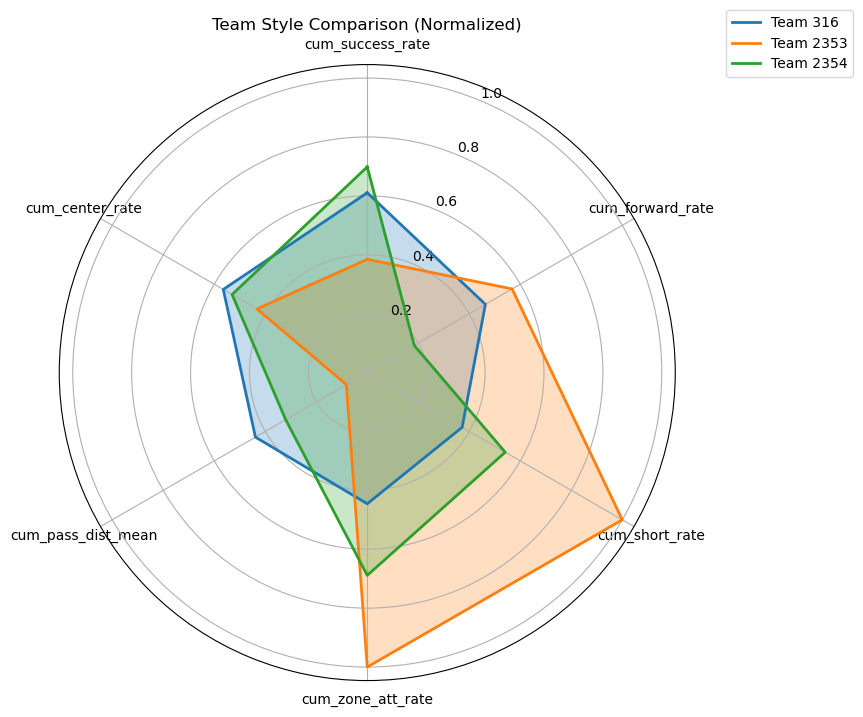

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def plot_team_comparison(df, team_ids, features):
    # 가장 최근 라운드의 데이터만 추출
    latest_stats = df.sort_values('round').groupby('team_id').tail(1)
    
    # 데이터 정규화 (0~1 사이로 변환하여 시각적 비교 용이하게 함)
    scaler = MinMaxScaler()
    plot_data = latest_stats.set_index('team_id')[features]
    scaled_values = scaler.fit_transform(plot_data)
    plot_data_scaled = pd.DataFrame(scaled_values, columns=features, index=plot_data.index)

    # 레이더 차트 설정
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] # 루프를 닫기 위해 시작점 추가

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for team_id in team_ids:
        values = plot_data_scaled.loc[team_id].tolist()
        values += values[:1] # 루프 닫기
        ax.plot(angles, values, label=f'Team {team_id}', linewidth=2)
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title("Team Style Comparison (Normalized)")
    plt.show()

# 비교하고 싶은 주요 피쳐 선택
target_features = [
    'cum_success_rate', 'cum_forward_rate', 'cum_short_rate', 
    'cum_zone_att_rate', 'cum_pass_dist_mean', 'cum_center_rate'
]

# 상위 3개 팀 예시 비교
sample_teams = team_cumulative['team_id'].unique()[:3]
plot_team_comparison(team_cumulative, sample_teams, target_features)

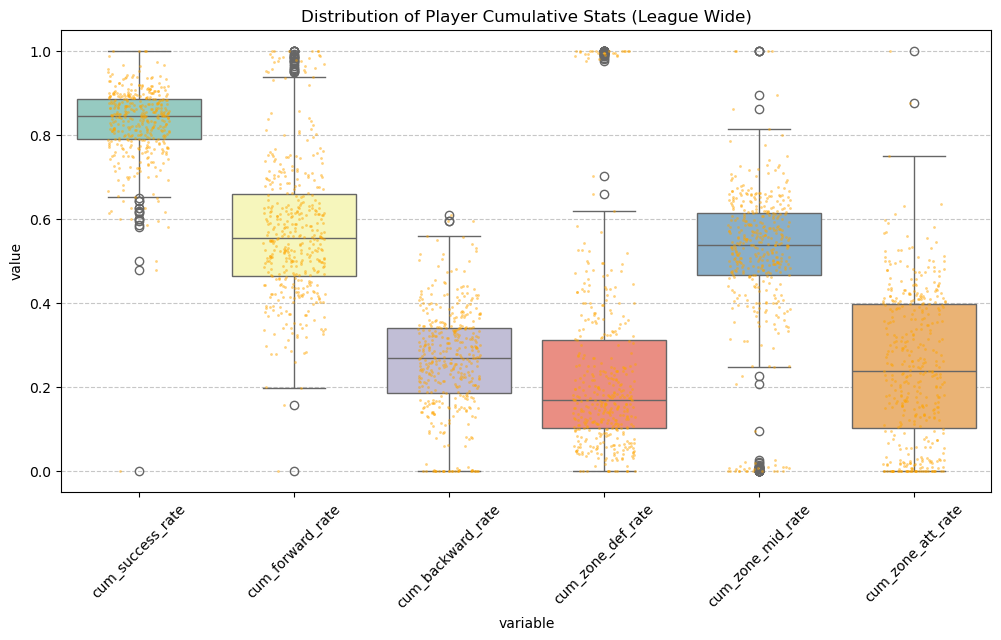

In [27]:
import seaborn as sns

def plot_stat_distribution(df, features):
    # 가장 최근 시점의 선수별 데이터
    latest_player_stats = df.sort_values('round').groupby('player_id').tail(1)
    
    # 시각화를 위해 데이터 재구성 (Melt)
    melted_df = latest_player_stats.melt(id_vars=['player_id'], value_vars=features)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='variable', y='value', data=melted_df, palette='Set3')
    sns.stripplot(x='variable', y='value', data=melted_df, color="orange", jitter=0.2, size=2, alpha=0.5)
    plt.xticks(rotation=45)
    plt.title("Distribution of Player Cumulative Stats (League Wide)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# 분석하고 싶은 피쳐들
player_features = [
    'cum_success_rate', 'cum_forward_rate', 'cum_backward_rate', 
    'cum_zone_def_rate', 'cum_zone_mid_rate', 'cum_zone_att_rate'
]
plot_stat_distribution(player_cumulative, player_features)

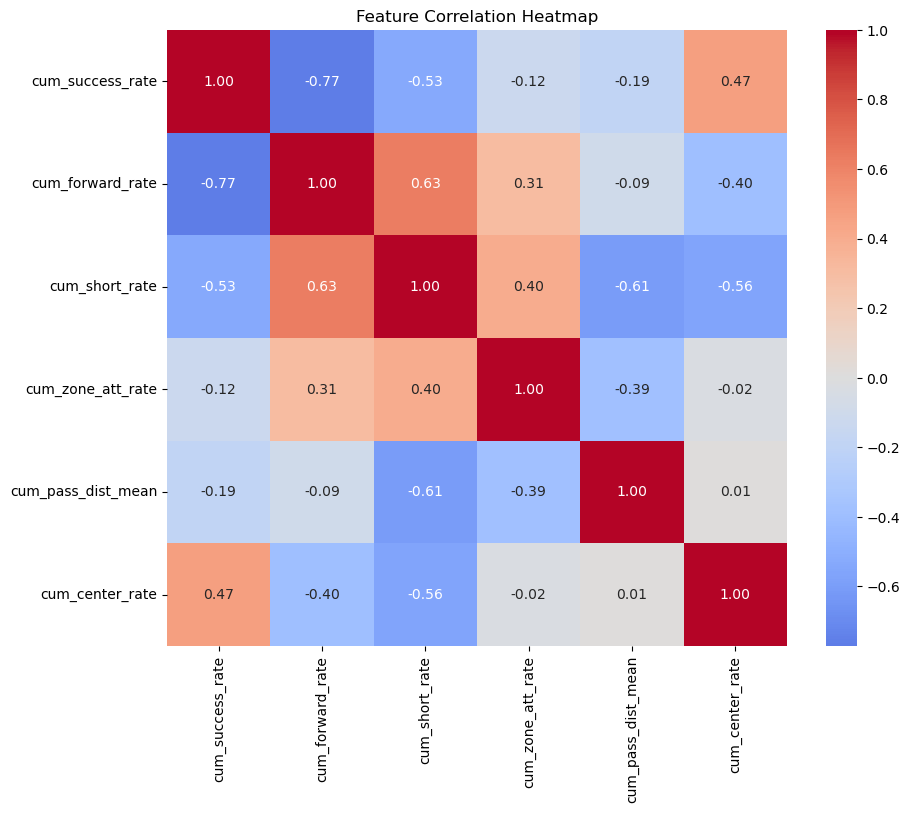

In [28]:
def plot_correlation_matrix(df, features):
    latest_stats = df.sort_values('round').groupby(df.columns[0]).tail(1)
    corr = latest_stats[features].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Feature Correlation Heatmap")
    plt.show()

# 팀 지표 간 상관관계 확인
plot_correlation_matrix(team_cumulative, target_features)

In [ ]:
from collections import defaultdict
import pandas as pd

def compute_standings_before_game(match_info):
    """각 팀이 진행하는 경기 라운드의 직전 라운드 종료 시점의 팀 순위 상태를 계산"""
    matches = match_info.copy()
    # 라운드(game_day) 순으로 정렬
    matches = matches.sort_values('game_day').reset_index(drop=True)
    
    team_stats = defaultdict(lambda: {'points': 0, 'gf': 0, 'ga': 0})
    standings_dict = {}
    
    # 리그에 참여하는 모든 팀 식별 (전체 순위표 구성을 위함)
    all_teams = sorted(list(set(matches['home_team_id']) | set(matches['away_team_id'])))
    
    # 라운드별로 그룹화하여 처리
    for round_num, round_matches in matches.groupby('game_day'):
        # 1. 현재 라운드 시작 전(즉, 직전 라운드까지의 결과 누적)의 순위표 계산
        team_list = []
        for t_id in all_teams:
            stats = team_stats[t_id]
            team_list.append({
                'team_id': t_id,
                'points': stats['points'],
                'gd': stats['gf'] - stats['ga'],
                'gf': stats['gf']
            })
        
        # 순위 정렬: 승점 -> 득실차 -> 다득점 (기존 로직 유지)
        team_list.sort(key=lambda x: (-x['points'], -x['gd'], -x['gf']))
        rank_map = {t['team_id']: i+1 for i, t in enumerate(team_list)}
        
        # 2. 이번 라운드에 경기가 있는 팀들에게 '직전 라운드 종료 시점'의 순위 정보를 기록
        for _, row in round_matches.iterrows():
            for team_id in [row['home_team_id'], row['away_team_id']]:
                standings_dict[(round_num, team_id)] = {
                    'rank': rank_map[team_id],
                    'points': team_stats[team_id]['points'],
                    'gd': team_stats[team_id]['gf'] - team_stats[team_id]['ga'],
                }
        
        # 3. 이번 라운드의 모든 경기 결과를 team_stats에 업데이트 (다음 라운드 순위 계산에 반영)
        for _, row in round_matches.iterrows():
            h_id, a_id = row['home_team_id'], row['away_team_id']
            h_score, a_score = row['home_score'], row['away_score']
            
            if h_score >= 0 and a_score >= 0:
                team_stats[h_id]['gf'] += h_score
                team_stats[h_id]['ga'] += a_score
                team_stats[a_id]['gf'] += a_score
                team_stats[a_id]['ga'] += h_score
                
                if h_score > a_score:
                    team_stats[h_id]['points'] += 3
                elif h_score < a_score:
                    team_stats[a_id]['points'] += 3
                else:
                    team_stats[h_id]['points'] += 1
                    team_stats[a_id]['points'] += 1
    
    return standings_dict

# standings_dict 계산 및 결과 출력
standings_dict = compute_standings_before_game(match_info)
print(f"순위 정보: {len(standings_dict)} entries")

순위 정보: 456 entries
{(1, 2354): {'rank': 3, 'points': 0, 'gd': 0}, (1, 4639): {'rank': 5, 'points': 0, 'gd': 0}, (1, 4640): {'rank': 6, 'points': 0, 'gd': 0}, (1, 4657): {'rank': 12, 'points': 0, 'gd': 0}, (1, 4648): {'rank': 11, 'points': 0, 'gd': 0}, (1, 316): {'rank': 1, 'points': 0, 'gd': 0}, (1, 4646): {'rank': 10, 'points': 0, 'gd': 0}, (1, 4220): {'rank': 4, 'points': 0, 'gd': 0}, (1, 4643): {'rank': 8, 'points': 0, 'gd': 0}, (1, 4641): {'rank': 7, 'points': 0, 'gd': 0}, (1, 4644): {'rank': 9, 'points': 0, 'gd': 0}, (1, 2353): {'rank': 2, 'points': 0, 'gd': 0}, (2, 4220): {'rank': 4, 'points': 3, 'gd': 1}, (2, 4640): {'rank': 5, 'points': 1, 'gd': 0}, (2, 4639): {'rank': 9, 'points': 0, 'gd': -1}, (2, 4644): {'rank': 10, 'points': 0, 'gd': -1}, (2, 2353): {'rank': 2, 'points': 3, 'gd': 1}, (2, 2354): {'rank': 3, 'points': 3, 'gd': 1}, (2, 4641): {'rank': 6, 'points': 1, 'gd': 0}, (2, 4657): {'rank': 8, 'points': 1, 'gd': 0}, (2, 316): {'rank': 12, 'points': 0, 'gd': -2}, (2, 4646

In [7]:
# 전역 평균 (결측 대체용)
global_player_avg = {
    'cum_pass_dist_mean': passes['pass_dist'].mean(),
    'cum_pass_dy_mean': passes['pass_dy'].mean(),
    'cum_pass_angle_mean': passes['pass_angle'].mean(),
    'cum_forward_rate': passes['is_forward'].mean(),
    'cum_backward_rate': passes['is_backward'].mean(),
    'cum_success_rate': passes['is_successful'].mean(),
    'cum_short_rate': passes['is_short'].mean(),
    'cum_zone_def_rate': passes['zone_def'].mean(),
    'cum_zone_att_rate': passes['zone_att'].mean(),
    'cum_left_rate': passes['is_left'].mean(),
    'cum_center_rate': passes['is_center'].mean(),
    'cum_right_rate': passes['is_right'].mean(),
    'cum_avg_start_x': passes['start_x'].mean(),
    'cum_avg_start_y': passes['start_y'].mean(),
    'cum_total_passes': 50,
    'cum_games_played': 5,
}

player_stats_dict = player_cumulative.set_index(['player_id', 'game_id']).to_dict('index')
team_stats_dict = team_cumulative.set_index(['team_id', 'game_id']).to_dict('index')

print("통계 딕셔너리 생성 완료")

통계 딕셔너리 생성 완료


Local Episode Stats: 100%|██████████| 15435/15435 [00:25<00:00, 604.15it/s]


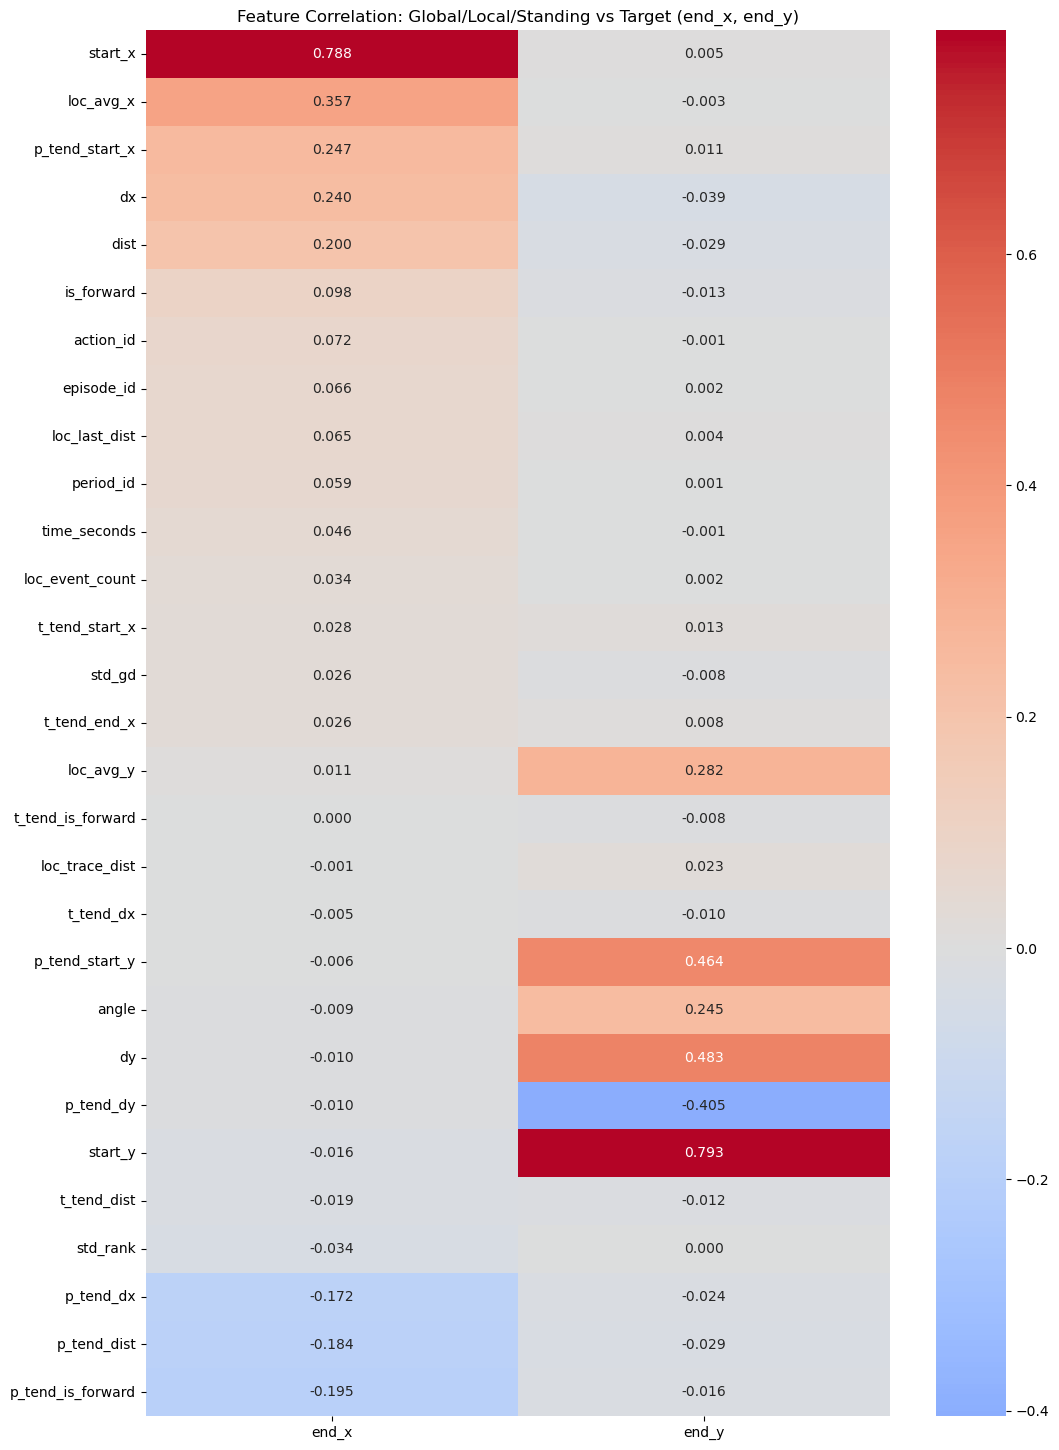

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def analyze_targeted_correlation(train_df, match_info, standings_dict):
    df = train_df.copy()
    
    # 1. 기본 물리량 계산 (전체 데이터 대상)
    # index 컬럼이 없다면 생성하여 순서 보장
    if 'index' not in df.columns:
        df = df.reset_index() 
    
    df['dx'] = df['end_x'] - df['start_x']
    df['dy'] = df['end_y'] - df['start_y']
    df['dist'] = np.sqrt(df['dx']**2 + df['dy']**2)
    df['angle'] = np.arctan2(df['dy'], df['dx'])
    df['is_forward'] = (df['dx'] > 0).astype(int)
    
    # 2. 글로벌 성향 계산 (전체 데이터 기준 성향 파악)
    # 선수별 성향
    player_global = df[df['type_name'] == 'Pass'].groupby('player_id').agg({
        'dist': 'mean', 'dx': 'mean', 'dy': 'mean', 'is_forward': 'mean',
        'start_x': 'mean', 'start_y': 'mean'
    }).add_prefix('p_tend_').reset_index()
    
    # 팀별 성향
    team_global = df[df['type_name'] == 'Pass'].groupby('team_id').agg({
        'dist': 'mean', 'dx': 'mean', 'is_forward': 'mean',
        'start_x': 'mean', 'end_x': 'mean'
    }).add_prefix('t_tend_').reset_index()

    # 3. 에피소드별 로컬 피처 계산
    local_feats_list = []
    # 에피소드 내 순서는 reset_index로 생성된 'index' 컬럼 사용
    for name, group in tqdm(df.groupby('game_episode'), desc="Local Episode Stats"):
        group = group.sort_values('index') 
        if len(group) < 2: continue
        
        last_pass = group.iloc[-1]
        prev_events = group.iloc[:-1]
        
        feat = {
            'game_episode': name,
            'loc_avg_x': prev_events['start_x'].mean(),
            'loc_avg_y': prev_events['start_y'].mean(),
            'loc_last_dist': prev_events.iloc[-1]['dist'] if 'dist' in prev_events.columns else 0,
            'loc_event_count': len(prev_events),
            'loc_trace_dist': np.sqrt((last_pass['start_x'] - prev_events.iloc[-1]['end_x'])**2 + 
                                      (last_pass['start_y'] - prev_events.iloc[-1]['end_y'])**2)
        }
        local_feats_list.append(feat)
    local_df = pd.DataFrame(local_feats_list)

    # 4. 데이터 통합 (마지막 패스 시점의 상황)
    target_df = df.groupby('game_episode').tail(1).copy()
    final_df = target_df.merge(local_df, on='game_episode', how='inner')
    final_df = final_df.merge(player_global, on='player_id', how='left')
    final_df = final_df.merge(team_global, on='team_id', how='left')
    
    # 순위 정보 추가
    game_round_map = match_info.set_index('game_id')['game_day'].to_dict()
    final_df['round'] = final_df['game_id'].map(game_round_map)
    final_df['std_rank'] = final_df.apply(lambda x: standings_dict.get((x['round'], x['team_id']), {}).get('rank', np.nan), axis=1)
    final_df['std_gd'] = final_df.apply(lambda x: standings_dict.get((x['round'], x['team_id']), {}).get('gd', np.nan), axis=1)

    # 5. 상관관계 분석 (Target: end_x, end_y)
    targets = ['end_x', 'end_y']
    
    # 수치형 컬럼만 자동 선택 (모든 피처 포함)
    numeric_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()
    # ID성 컬럼 및 타겟과 직접 연관된 dx, dy 등은 분석의 재미를 위해 포함하되 
    # 나중에 피처 선택시에는 주의해야 합니다.
    features_to_analyze = [c for c in numeric_cols if c not in ['game_id', 'team_id', 'player_id', 'round', 'index']]
    
    # 전체 상관관계
    full_corr = final_df[features_to_analyze].corr()[targets].drop(targets, errors='ignore')

    # 시각화
    plt.figure(figsize=(12, 18))
    sns.heatmap(full_corr.sort_values(by='end_x', ascending=False), annot=True, cmap='coolwarm', center=0, fmt=".3f")
    plt.title("Feature Correlation: Global/Local/Standing vs Target (end_x, end_y)")
    plt.show()

    return final_df, full_corr

# 실행
final_data, corr_matrix = analyze_targeted_correlation(train_df, match_info, standings_dict)

=== [end_x] 관련 피처 VIF 검증 ===
     Feature       VIF
1  loc_avg_x  9.967212
3       dist  9.069051
0    start_x  8.086953
2         dx  6.441341
4  p_tend_dx  2.229731

=== [end_y] 관련 피처 VIF 검증 ===
     Feature       VIF
0    start_y  5.487667
2  loc_avg_y  4.971973
1         dy  1.530885
3      angle  1.525535
4  p_tend_dy  1.402168


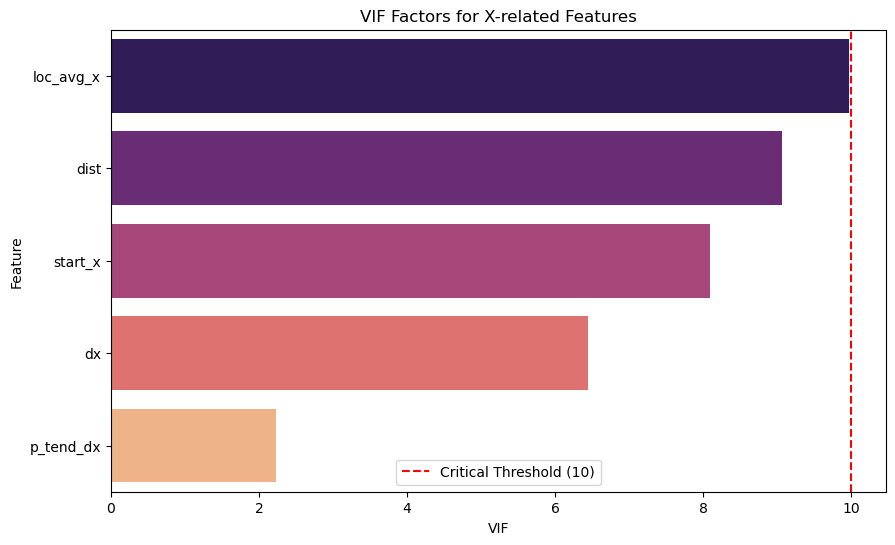

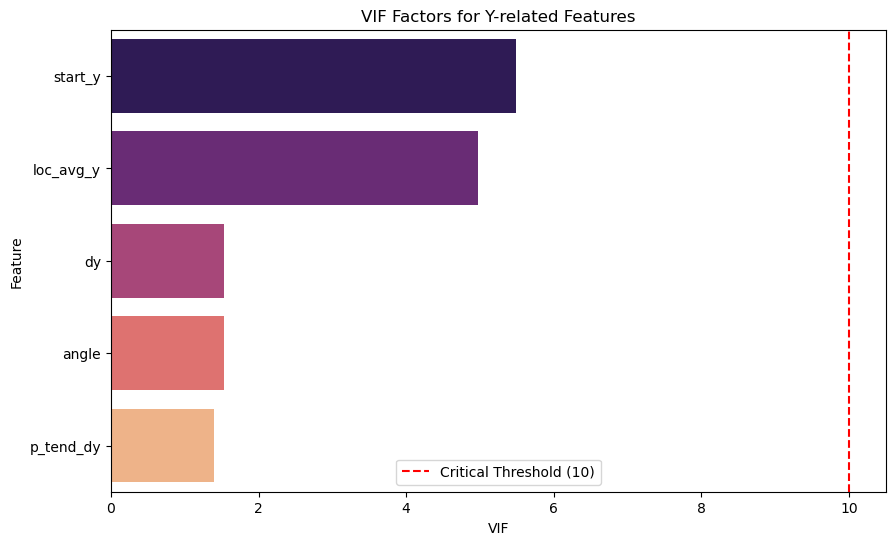

In [30]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

def check_vif(df, feature_list):
    # 결측치 제거 및 분석 데이터 준비
    vif_data = df[feature_list].dropna()
    
    # VIF 계산용 데이터프레임 생성
    vif_df = pd.DataFrame()
    vif_df["Feature"] = feature_list
    vif_df["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(len(feature_list))]
    
    return vif_df.sort_values(by="VIF", ascending=False)

# 1. 분석 대상 피처 리스트 정의 (정리해주신 내용 기반)
# x_features = ['start_x', 'loc_avg_x', 'p_tend_start_x', 'dx', 'dist', 'p_tend_dx', 'p_tend_dist', 'p_tend_is_forward']
x_features = ['start_x', 'loc_avg_x','dx', 'dist', 'p_tend_dx']
# y_features = ['start_y', 'dy', 'p_tend_start_y', 'loc_avg_y', 'angle', 'p_tend_dy']
y_features = ['start_y', 'dy', 'loc_avg_y', 'angle', 'p_tend_dy']

# 2. X 관련 피처 VIF 확인
print("=== [end_x] 관련 피처 VIF 검증 ===")
vif_x = check_vif(final_data, x_features)
print(vif_x)

# 3. Y 관련 피처 VIF 확인
print("\n=== [end_y] 관련 피처 VIF 검증 ===")
vif_y = check_vif(final_data, y_features)
print(vif_y)

# 4. 시각화 (VIF 수치 확인용)
plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='Feature', data=vif_x, palette='magma')
plt.axvline(x=10, color='red', linestyle='--', label='Critical Threshold (10)')
plt.title("VIF Factors for X-related Features")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='Feature', data=vif_y, palette='magma')
plt.axvline(x=10, color='red', linestyle='--', label='Critical Threshold (10)')
plt.title("VIF Factors for Y-related Features")
plt.legend()
plt.show()

피쳐 계산

In [31]:
# =========================================
# KLeague Episode Last-pass (end_x, end_y) Prediction
# Transformer + (player_id, team_id) embeddings
# Using VIF-selected features from kleague_v35.ipynb
# =========================================

import os
import math
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm


# -----------------------------
# 0) Config
# -----------------------------
class CFG:
    seed = 42
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "open_track1/train.csv"

    # VIF-selected features (from kleague_v35.ipynb cell)
    x_features = [
        "start_x", "loc_avg_x",
        "dx", "dist", "p_tend_dx"
    ]
    y_features = [
        "start_y", "dy",
        "loc_avg_y", "angle", "p_tend_dy"
    ]
    # union (preserve order, remove duplicates)
    selected_features = list(dict.fromkeys(x_features + y_features))

    # sequence
    max_len = 64               # episodes longer than this -> keep last max_len events
    batch_size = 64
    num_workers = 0

    # model
    player_emb_dim = 32
    team_emb_dim = 16
    d_model = 256
    n_heads = 8
    n_layers = 6
    ff_dim = 384
    dropout = 0.15

    # training
    epochs = 40
    lr = 3e-4
    weight_decay = 1e-2
    grad_clip = 1.0
    use_amp = True
    early_stop_patience = 5

    # split
    val_ratio = 0.1
    split_by_game_id = True  # game_id 단위로 나누고 싶으면 True


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


seed_everything(CFG.seed)
print("Device:", CFG.device)
print("Selected features:", CFG.selected_features)
print("Num features:", len(CFG.selected_features))

Device: cuda
Selected features: ['start_x', 'loc_avg_x', 'dx', 'dist', 'p_tend_dx', 'start_y', 'dy', 'loc_avg_y', 'angle', 'p_tend_dy']
Num features: 10


In [ ]:
# -----------------------------
# 1) Load & basic ordering
# -----------------------------
df = pd.read_csv(CFG.train_csv)

# Ensure stable order inside episode
# (period_id, time_seconds, action_id)로 정렬하는게 보통 안전
if "action_id" not in df.columns:
    # 혹시 없으면 fallback
    df["action_id"] = 0

# 원본 인덱스를 "episode 내부 순서"로 쓰기 위해 생성
df = df.reset_index().rename(columns={"index": "row_idx"})

# game_episode가 없다면 만들어야 함 (여기서는 이미 있음)
if "game_episode" not in df.columns:
    df["game_episode"] = (
        df["game_id"].astype(str) + "_" + df["episode_id"].astype(str)
    )

df = df.sort_values(["game_episode", "period_id", "time_seconds", "action_id", "row_idx"]).reset_index(drop=True)


# -----------------------------
# 2) Feature engineering needed for VIF features
#    - dx, dy, dist, angle
#    - player global tendencies: p_tend_*
#    - local rolling avg: loc_avg_x, loc_avg_y
# -----------------------------
# 기본 물리량
for col in ["start_x", "start_y", "end_x", "end_y"]:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col}")

df["dx"] = df["end_x"] - df["start_x"]
df["dy"] = df["end_y"] - df["start_y"]
df["dist"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)
df["angle"] = np.arctan2(df["dy"], df["dx"])
df["is_forward"] = (df["dx"] > 0).astype(np.float32)

# NaN 안전 처리
for c in ["dx", "dy", "dist", "angle", "is_forward"]:
    df[c] = df[c].replace([np.inf, -np.inf], np.nan).fillna(0.0)

# -----------------------------
# player global tendencies (Pass event 기반)
# p_tend_start_x, p_tend_start_y, p_tend_dx, p_tend_dy, p_tend_dist, p_tend_is_forward
# -----------------------------
pass_mask = (df["type_name"].astype(str) == "Pass")
player_global = (
    df.loc[pass_mask]
      .groupby("player_id", as_index=False)
      .agg({
          "start_x": "mean",
          "start_y": "mean",
          "dx": "mean",
          "dy": "mean",
          "dist": "mean",
          "is_forward": "mean",
      })
      .rename(columns={
          "start_x": "p_tend_start_x",
          "start_y": "p_tend_start_y",
          "dx": "p_tend_dx",
          "dy": "p_tend_dy",
          "dist": "p_tend_dist",
          "is_forward": "p_tend_is_forward",
      })
)

df = df.merge(player_global, on="player_id", how="left")

# player tendency NaN -> 전체 평균으로 대체
for c in ["p_tend_start_x", "p_tend_start_y", "p_tend_dx", "p_tend_dy", "p_tend_dist", "p_tend_is_forward"]:
    df[c] = df[c].fillna(df[c].mean())

# -----------------------------
# loc_avg_x, loc_avg_y : episode 내 "이전 이벤트들의 start_x/y rolling mean"
# -----------------------------
df["loc_avg_x"] = (
    df.groupby("game_episode")["start_x"]
      .apply(lambda s: s.shift(1).expanding().mean())
      .reset_index(level=0, drop=True)
)
df["loc_avg_y"] = (
    df.groupby("game_episode")["start_y"]
      .apply(lambda s: s.shift(1).expanding().mean())
      .reset_index(level=0, drop=True)
)

# 첫 이벤트는 이전값이 없으니 자기 start로 대체(또는 0/전체평균도 가능)
df["loc_avg_x"] = df["loc_avg_x"].fillna(df["start_x"])
df["loc_avg_y"] = df["loc_avg_y"].fillna(df["start_y"])

# -----------------------------
# 3) Label definition + leakage prevention on last event
#    label = end_x,end_y of last row in episode
#    last row의 dx/dy/dist/angle은 end_x/end_y로부터 계산되므로 0으로 마스킹
# -----------------------------
# episode의 마지막 row index(전역 df index)
last_idx = df.groupby("game_episode").tail(1).index

# 라벨
episode_last = df.loc[last_idx, ["game_episode", "game_id", "end_x", "end_y"]].reset_index(drop=True)

# 누수 방지: 마지막 이벤트의 dx/dy/dist/angle은 라벨 사용하므로 제거
df.loc[last_idx, ["dx", "dy", "dist", "angle"]] = 0.0


# -----------------------------
# 4) ID mapping for embeddings (0 = PAD)
# -----------------------------
# player_id / team_id -> contiguous int
player_ids = df["player_id"].astype(int).values
team_ids = df["team_id"].astype(int).values

uniq_players = np.unique(player_ids)
uniq_teams = np.unique(team_ids)

player2idx = {pid: i+1 for i, pid in enumerate(uniq_players)}  # 0 is PAD
team2idx = {tid: i+1 for i, tid in enumerate(uniq_teams)}      # 0 is PAD

df["player_idx"] = [player2idx[int(x)] for x in player_ids]
df["team_idx"] = [team2idx[int(x)] for x in team_ids]

n_players = len(player2idx) + 1
n_teams = len(team2idx) + 1

print("n_players:", n_players, "n_teams:", n_teams)


# -----------------------------
# 5) Train/Val split by episode
# -----------------------------
episodes = episode_last["game_episode"].values
if CFG.split_by_game_id:
    # game_id 단위 split
    game_ids = episode_last["game_id"].values
    uniq_games = np.unique(game_ids)
    rng = np.random.default_rng(CFG.seed)
    rng.shuffle(uniq_games)
    n_val_games = int(len(uniq_games) * CFG.val_ratio)
    val_games = set(uniq_games[:n_val_games])

    is_val_ep = np.array([gid in val_games for gid in game_ids])
else:
    rng = np.random.default_rng(CFG.seed)
    perm = rng.permutation(len(episodes))
    n_val = int(len(episodes) * CFG.val_ratio)
    val_idx = set(perm[:n_val])
    is_val_ep = np.array([i in val_idx for i in range(len(episodes))])

train_eps = episodes[~is_val_ep]
val_eps = episodes[is_val_ep]

train_ep_set = set(train_eps)
val_ep_set = set(val_eps)

print(f"Episodes: total={len(episodes)} train={len(train_eps)} val={len(val_eps)}")


# -----------------------------
# 6) Normalization stats (train rows only)
# -----------------------------
feat_cols = CFG.selected_features
for c in feat_cols:
    if c not in df.columns:
        raise ValueError(f"Feature column missing: {c}")

row_is_train = df["game_episode"].isin(train_ep_set).values

feat_mat_train = df.loc[row_is_train, feat_cols].astype(np.float32)
feat_mean = feat_mat_train.mean(axis=0).values
feat_std = feat_mat_train.std(axis=0).values
feat_std = np.where(feat_std < 1e-6, 1.0, feat_std)

print("Feature mean/std ready.")


def normalize_feats(x: np.ndarray) -> np.ndarray:
    return (x - feat_mean) / feat_std


# -----------------------------
# 7) Build contiguous episode slices
#    df는 game_episode로 정렬되어 있으므로 contiguous segment 가능
# -----------------------------
ep_arr = df["game_episode"].values
# unique episodes in df order
uniq_eps, start_pos, counts = np.unique(ep_arr, return_index=True, return_counts=True)

# episode -> (start, count) map
ep2slice = {e: (int(s), int(c)) for e, s, c in zip(uniq_eps, start_pos, counts)}

# label map
ep2y = {
    row["game_episode"]: (float(row["end_x"]), float(row["end_y"]))
    for _, row in episode_last.iterrows()
}


# -----------------------------
# 8) Dataset
# -----------------------------
class EpisodeDataset(Dataset):
    def __init__(self, df: pd.DataFrame, episodes: np.ndarray, max_len: int):
        self.df = df
        self.episodes = episodes
        self.max_len = max_len

        self.feat_cols = feat_cols

        # numpy views for speed
        self.feats_np = df[self.feat_cols].astype(np.float32).values
        self.player_np = df["player_idx"].astype(np.int64).values
        self.team_np = df["team_idx"].astype(np.int64).values

    def __len__(self):
        return len(self.episodes)

    def __getitem__(self, idx: int):
        ep = self.episodes[idx]
        s, c = ep2slice[ep]
        e = s + c

        # slice episode rows
        feats = self.feats_np[s:e]
        pids = self.player_np[s:e]
        tids = self.team_np[s:e]

        # normalize
        feats = normalize_feats(feats)

        # truncate (keep last max_len)
        if c > self.max_len:
            feats = feats[-self.max_len:]
            pids = pids[-self.max_len:]
            tids = tids[-self.max_len:]
            c = self.max_len

        # pad to max_len (right pad)
        pad_len = self.max_len - c
        if pad_len > 0:
            feats = np.pad(feats, ((0, pad_len), (0, 0)), mode="constant", constant_values=0.0)
            pids = np.pad(pids, (0, pad_len), mode="constant", constant_values=0)
            tids = np.pad(tids, (0, pad_len), mode="constant", constant_values=0)

        attn_mask = np.zeros((self.max_len,), dtype=np.bool_)
        attn_mask[:c] = True

        y = np.array(ep2y[ep], dtype=np.float32)  # (end_x, end_y)

        return {
            "x": torch.from_numpy(feats),           # (L, F)
            "player": torch.from_numpy(pids),       # (L,)
            "team": torch.from_numpy(tids),         # (L,)
            "mask": torch.from_numpy(attn_mask),    # (L,)
            "y": torch.from_numpy(y),               # (2,)
        }


def collate_fn(batch):
    x = torch.stack([b["x"] for b in batch], dim=0)            # (B,L,F)
    player = torch.stack([b["player"] for b in batch], dim=0)  # (B,L)
    team = torch.stack([b["team"] for b in batch], dim=0)      # (B,L)
    mask = torch.stack([b["mask"] for b in batch], dim=0)      # (B,L)
    y = torch.stack([b["y"] for b in batch], dim=0)            # (B,2)
    return x, player, team, mask, y


train_ds = EpisodeDataset(df, train_eps, CFG.max_len)
val_ds = EpisodeDataset(df, val_eps, CFG.max_len)

train_loader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)


In [ ]:
# -----------------------------
# 9) Model: Transformer Encoder
# -----------------------------
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        self.pos = nn.Embedding(max_len, d_model)

    def forward(self, x):
        # x: (B,L,d)
        B, L, _ = x.shape
        pos_idx = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        return x + self.pos(pos_idx)


class EpisodeTransformer(nn.Module):
    def __init__(
        self,
        num_features: int,
        n_players: int,
        n_teams: int,
        player_emb_dim: int,
        team_emb_dim: int,
        d_model: int,
        n_heads: int,
        n_layers: int,
        ff_dim: int,
        dropout: float,
        max_len: int,
    ):
        super().__init__()

        self.player_emb = nn.Embedding(n_players, player_emb_dim, padding_idx=0)
        self.team_emb = nn.Embedding(n_teams, team_emb_dim, padding_idx=0)

        in_dim = num_features + player_emb_dim + team_emb_dim
        self.in_proj = nn.Linear(in_dim, d_model)

        self.pos = PositionalEmbedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 2),
        )

    def forward(self, x, player, team, mask):
        """
        x: (B,L,F)
        player/team: (B,L)
        mask: (B,L) boolean, True for valid tokens
        """
        p = self.player_emb(player)  # (B,L,pe)
        t = self.team_emb(team)      # (B,L,te)
        h = torch.cat([x, p, t], dim=-1)  # (B,L,F+pe+te)
        h = self.in_proj(h)
        h = self.pos(h)
        h = self.dropout(h)

        # transformer expects src_key_padding_mask: True for PAD
        key_padding_mask = ~mask  # (B,L)
        h = self.encoder(h, src_key_padding_mask=key_padding_mask)

        # pool: last valid token
        lengths = mask.long().sum(dim=1)  # (B,)
        last_idx = (lengths - 1).clamp(min=0)  # (B,)
        pooled = h[torch.arange(h.size(0), device=h.device), last_idx]  # (B,d)

        out = self.head(pooled)  # (B,2)
        return out

In [ ]:
model = EpisodeTransformer(
    num_features=len(CFG.selected_features),
    n_players=n_players,
    n_teams=n_teams,
    player_emb_dim=CFG.player_emb_dim,
    team_emb_dim=CFG.team_emb_dim,
    d_model=CFG.d_model,
    n_heads=CFG.n_heads,
    n_layers=CFG.n_layers,
    ff_dim=CFG.ff_dim,
    dropout=CFG.dropout,
    max_len=CFG.max_len,
).to(CFG.device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=(CFG.use_amp and CFG.device == "cuda"))


# -----------------------------
# 10) Train / Eval
# -----------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_dist = 0.0
    n = 0

    for x, player, team, mask, y in loader:
        x = x.to(CFG.device, non_blocking=True)
        player = player.to(CFG.device, non_blocking=True)
        team = team.to(CFG.device, non_blocking=True)
        mask = mask.to(CFG.device, non_blocking=True)
        y = y.to(CFG.device, non_blocking=True)

        pred = model(x, player, team, mask)
        loss = F.smooth_l1_loss(pred, y, reduction="mean")

        dist = torch.sqrt(((pred - y) ** 2).sum(dim=1)).mean()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_dist += dist.item() * bs
        n += bs

    return total_loss / n, total_dist / n


def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    total_dist = 0.0
    n = 0

    for x, player, team, mask, y in tqdm(loader, desc="train", leave=False):
        x = x.to(CFG.device, non_blocking=True)
        player = player.to(CFG.device, non_blocking=True)
        team = team.to(CFG.device, non_blocking=True)
        mask = mask.to(CFG.device, non_blocking=True)
        y = y.to(CFG.device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(CFG.use_amp and CFG.device == "cuda")):
            pred = model(x, player, team, mask)
            loss = F.smooth_l1_loss(pred, y, reduction="mean")

        scaler.scale(loss).backward()

        if CFG.grad_clip is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip)

        scaler.step(optimizer)
        scaler.update()

        dist = torch.sqrt(((pred.detach() - y) ** 2).sum(dim=1)).mean()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_dist += dist.item() * bs
        n += bs

    return total_loss / n, total_dist / n


best_val_dist = float("inf")
pat = 0
best_path = "best_transformer_lastpass.pt"

for epoch in range(1, CFG.epochs + 1):
    tr_loss, tr_dist = train_one_epoch(model, train_loader)
    va_loss, va_dist = evaluate(model, val_loader)

    print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f} train_dist {tr_dist:.4f} | val_loss {va_loss:.4f} val_dist {va_dist:.4f}")

    if va_dist < best_val_dist:
        best_val_dist = va_dist
        pat = 0
        torch.save(model.state_dict(), best_path)
        print(f"  -> saved best: {best_val_dist:.4f}")
    else:
        pat += 1
        if pat >= CFG.early_stop_patience:
            print("Early stopping.")
            break

print("Best val dist:", best_val_dist)
print("Best model saved at:", best_path)


Device: cuda
Selected features: ['start_x', 'loc_avg_x', 'dx', 'dist', 'p_tend_dx', 'start_y', 'dy', 'loc_avg_y', 'angle', 'p_tend_dy']
Num features: 10
n_players: 447 n_teams: 13
Episodes: total=15435 train=13984 val=1451
Feature mean/std ready.


Epoch 01 | train_loss 28.0631 train_dist 44.7104 | val_loss 17.2740 val_dist 27.7779
  -> saved best: 27.7779


Epoch 02 | train_loss 15.4684 train_dist 25.0208 | val_loss 12.0602 val_dist 19.9100
  -> saved best: 19.9100


Epoch 03 | train_loss 11.2816 train_dist 18.7039 | val_loss 10.1457 val_dist 17.0357
  -> saved best: 17.0357


Epoch 04 | train_loss 10.6516 train_dist 17.7515 | val_loss 10.0346 val_dist 16.7896
  -> saved best: 16.7896


Epoch 05 | train_loss 10.3528 train_dist 17.2673 | val_loss 9.8262 val_dist 16.4879
  -> saved best: 16.4879


Epoch 06 | train_loss 10.2115 train_dist 17.0527 | val_loss 9.8064 val_dist 16.4147
  -> saved best: 16.4147


Epoch 07 | train_loss 10.0402 train_dist 16.7790 | val_loss 9.6663 val_dist 16.1761
  -> saved best: 16.1761


Epoch 08 | train_loss 9.9123 train_dist 16.5689 | val_loss 9.5872 val_dist 16.0946
  -> saved best: 16.0946


Epoch 09 | train_loss 9.7642 train_dist 16.3479 | val_loss 9.8483 val_dist 16.5597


Epoch 10 | train_loss 9.6274 train_dist 16.1038 | val_loss 9.7345 val_dist 16.3471


Epoch 11 | train_loss 9.5066 train_dist 15.9489 | val_loss 9.7607 val_dist 16.3949


Epoch 12 | train_loss 9.3964 train_dist 15.7729 | val_loss 9.9401 val_dist 16.7014


Epoch 13 | train_loss 9.2119 train_dist 15.4857 | val_loss 9.7762 val_dist 16.4352
Early stopping.
Best val dist: 16.09458392739378
Best model saved at: best_transformer_lastpass.pt
